# Time-Series Forecasting of Carbon Monoxide and Nitrogen Dioxide Levels

Build predictive models to forecast daily or hourly concentrations of **CO(GT)** and **NO₂(GT)** based on historical data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
url = 'https://raw.githubusercontent.com/rashakil-ds/Public-Datasets/refs/heads/main/airquality.csv'
try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

Dataset loaded successfully.


In [3]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [4]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

# Project Workflow

### **Deliverables**:
1. **Forecasting Models**:
   - Trained models for `CO(GT)` and `NO₂(GT)`.
2. **Forecast Visualization**:
   - Plots showing historical trends and future predictions.
3. **Evaluation Report**:
   - Metrics and comparison of different forecasting models.
4. **Insights and Recommendations**:
   - Suggestions for mitigating high levels of these gases based on predictions.


### 1. Data Preprocessing
- **Date-Time Parsing**:
  - Combine the `Date` and `Time` columns into a single `datetime` column.
  - Set the `datetime` column as the index of the dataset.
- **Resampling**:
  - Aggregate the data into meaningful time intervals (e.g., hourly or daily averages).
- **Handle Missing Values**:
  - Use interpolation, mean, or advanced imputation techniques to fill missing data for `CO(GT)` and `NO₂(GT)`.
- **Outlier Detection**:
  - Remove or cap extreme values in `CO(GT)` and `NO₂(GT)` using statistical thresholds.

In [5]:
# Combine 'Date' and 'Time' columns into a single datetime column
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['Date'], row['Time']), axis=1)

In [6]:
# Set the datetime column as the index
df.set_index('datetime', inplace=True)

In [7]:
# Drop original 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [8]:
# Clean up column names by removing spaces and extra characters
df.columns = df.columns.str.strip()

In [9]:
# Replace any missing or invalid values (like -200) with NaN
df.replace(-200, np.nan, inplace=True)

In [10]:
# Handle Missing Values for key variables using linear interpolation
df['CO(GT)'] = df['CO(GT)'].interpolate(method='linear')
df['NO2(GT)'] = df['NO2(GT)'].interpolate(method='linear')
print("Missing values for 'CO(GT)' and 'NO2(GT)' have been handled via interpolation.")

Missing values for 'CO(GT)' and 'NO2(GT)' have been handled via interpolation.


In [11]:
# Resampling: Aggregate the data into daily averages
df_daily = df.resample('D').mean()
df = df_daily.dropna() # Drop any remaining NaNs after resampling
print("Data has been resampled to a daily frequency and missing values handled.")
print(f"New dataset shape after resampling: {df.shape}")

Data has been resampled to a daily frequency and missing values handled.
New dataset shape after resampling: (44, 13)


In [12]:
# Outlier Detection: Cap extreme values using the Interquartile Range (IQR) method
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    print(f"Outliers for '{column}' have been capped using the IQR method.")
    return df

df = cap_outliers_iqr(df, 'CO(GT)')
df = cap_outliers_iqr(df, 'NO2(GT)')
print("Outliers for key variables have been handled.")

Outliers for 'CO(GT)' have been capped using the IQR method.
Outliers for 'NO2(GT)' have been capped using the IQR method.
Outliers for key variables have been handled.


### 2. Exploratory Data Analysis (EDA)
- **Trend Analysis**:
  - Visualize the long-term trends of `CO(GT)` and `NO₂(GT)`.
- **Seasonality**:
  - Identify seasonal patterns (e.g., daily or yearly fluctuations).
- **Correlation Analysis**:
  - Explore relationships between `CO(GT)`, `NO₂(GT)`, and other features (e.g., temperature or humidity).


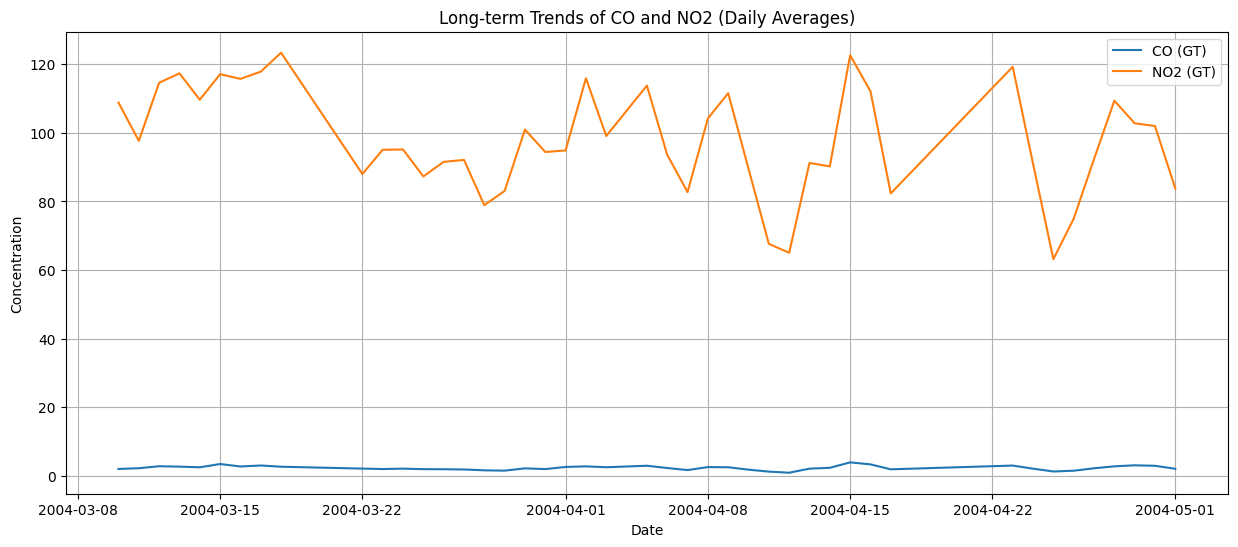

Plotted long-term trends.


In [13]:
# Trend Analysis: Visualize the long-term trends of CO(GT) and NO2(GT)
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['CO(GT)'], label='CO (GT)')
plt.plot(df.index, df['NO2(GT)'], label='NO2 (GT)')
plt.title('Long-term Trends of CO and NO2 (Daily Averages)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()
print("Plotted long-term trends.")

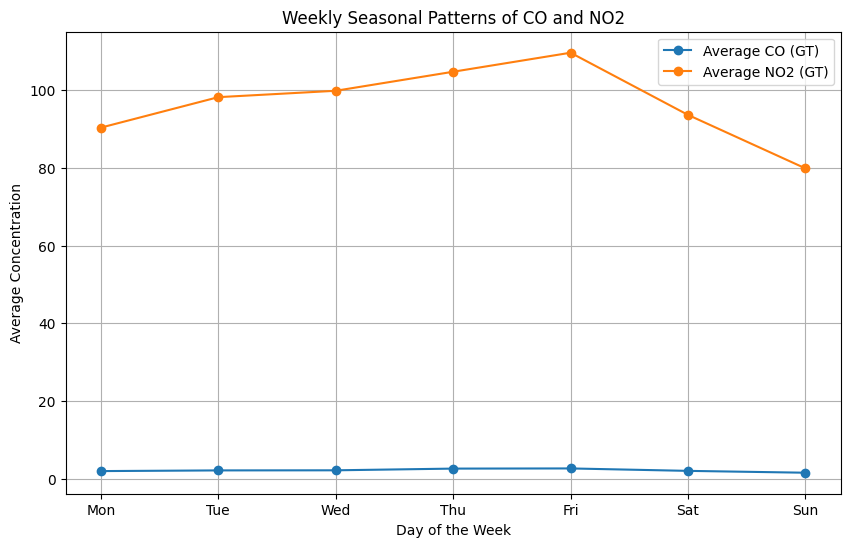

Plotted weekly seasonal patterns.


In [14]:
# Seasonality: Identify daily seasonal patterns (Note: With daily resampling, we'll look for weekly/monthly patterns instead)
# With daily resampling, plotting daily hourly patterns is no longer meaningful.
# Let's plot the average concentration by day of the week to check for weekly seasonality.
df['day_of_week'] = df.index.dayofweek
df_weekly = df.groupby('day_of_week')[['CO(GT)', 'NO2(GT)']].mean()
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly['CO(GT)'], marker='o', label='Average CO (GT)')
plt.plot(df_weekly.index, df_weekly['NO2(GT)'], marker='o', label='Average NO2 (GT)')
plt.title('Weekly Seasonal Patterns of CO and NO2')
plt.xlabel('Day of the Week')
plt.ylabel('Average Concentration')
plt.xticks(np.arange(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend()
plt.grid(True)
plt.show()
print("Plotted weekly seasonal patterns.")

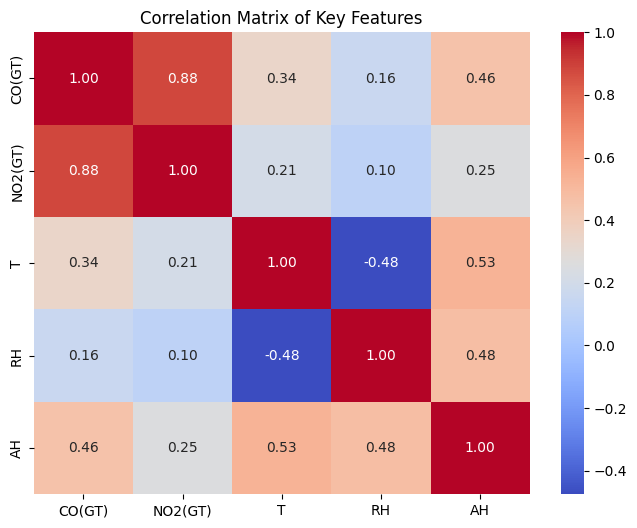

Plotted correlation matrix.


In [15]:
# Correlation Analysis: Explore relationships between key features
# Select relevant columns for correlation analysis
corr_cols = ['CO(GT)', 'NO2(GT)', 'T', 'RH', 'AH']
corr_matrix = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.show()
print("Plotted correlation matrix.")


### 3. Feature Engineering
- Create lag features for `CO(GT)` and `NO₂(GT)` to incorporate historical values.
- Add time-based features (e.g., hour of the day, day of the week, month).
- Include environmental factors (`T`, `RH`, `AH`) as predictors.


In [16]:
# Function to create lag features for a given series
def create_lag_features(df, series, lags):
    for i in range(1, lags + 1):
        df[f'{series}_lag_{i}'] = df[series].shift(i)
    return df

# Create features for CO(GT)
df = create_lag_features(df, 'CO(GT)', 5)

# Create features for NO2(GT)
df = create_lag_features(df, 'NO2(GT)', 5)

In [17]:
# Add time-based features
# 'hour' is no longer available due to daily resampling, but 'month' is.
df['month'] = df.index.month

In [18]:
# Drop NaN values created by lagging
df.dropna(inplace=True)
print("Lag and time-based features created.")
print(f"Dataset shape after feature engineering: {df.shape}")

Lag and time-based features created.
Dataset shape after feature engineering: (39, 25)


### 4. Time-Series Forecasting
- Train separate models for **CO(GT)** and **NO₂(GT)**.
- Explore the following forecasting approaches:
  - **Statistical Models**:
    - Classical models like ARIMA or SARIMA for univariate forecasting.
  - **Machine Learning Models**:
    - Use regression models trained on lag features and external predictors.
  - **Deep Learning Models**:
    - Apply LSTM, GRU, or other RNN-based models for sequence forecasting.
- Evaluate and compare the models.


In [19]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print(f"Training set size: {len(train)} | Testing set size: {len(test)}")

Training set size: 31 | Testing set size: 8


In [20]:
# Define features and target variables
features_co = [col for col in df.columns if 'CO(GT)_lag' in col or col in ['day_of_week', 'month', 'T', 'RH', 'AH']]
target_co = 'CO(GT)'

features_no2 = [col for col in df.columns if 'NO2(GT)_lag' in col or col in ['day_of_week', 'month', 'T', 'RH', 'AH']]
target_no2 = 'NO2(GT)'

In [21]:
# --- Model 1: Linear Regression for CO(GT) ---
print("\n--- Training Linear Regression Model for CO(GT) ---")
model_co_lr = LinearRegression()
model_co_lr.fit(train[features_co], train[target_co])
predictions_co_lr = model_co_lr.predict(test[features_co])


--- Training Linear Regression Model for CO(GT) ---


In [22]:
# --- Model 2: Deep Learning (LSTM) for CO(GT) ---
print("--- Training LSTM Model for CO(GT) ---")

# Prepare data for LSTM: scaling and reshaping
# LSTM models perform best when data is scaled to a small range, e.g., 0-1
# We need to drop columns that are not in the test set to avoid errors with the LSTM model.
df_lstm = df[features_co + [target_co]].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Create sequences for LSTM training
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :-1])
        y.append(data[i + n_steps, -1])
    return np.array(X), np.array(y)

n_steps = 5 # Using the same number of lags as the linear model
X_scaled, y_scaled = create_sequences(scaled_data, n_steps)

# Split scaled data into train and test
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle=False
)

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, verbose=0)
predictions_lstm = model_lstm.predict(X_test_lstm)

# Invert predictions to original scale
predictions_lstm_full = np.zeros((len(predictions_lstm), scaled_data.shape[1]))
predictions_lstm_full[:, -1] = predictions_lstm[:, 0]
predictions_lstm_orig = scaler.inverse_transform(predictions_lstm_full)[:, -1]

--- Training LSTM Model for CO(GT) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


In [23]:
# --- Model 3: ARIMA for NO2(GT) ---
print("--- Training ARIMA Model for NO2(GT) ---")
# For a proper evaluation, we'd use a rolling forecast, but for simplicity, we'll fit on the train set
# and predict on the test set.
model_no2_arima = ARIMA(train[target_no2], order=(5,1,0)) # Example ARIMA order (p,d,q)
model_no2_arima_fit = model_no2_arima.fit()
predictions_no2_arima = model_no2_arima_fit.forecast(steps=len(test))

--- Training ARIMA Model for NO2(GT) ---


### 5. Model Evaluation
- Use appropriate metrics for forecasting:
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Percentage Error (MAPE)
- Plot actual vs. predicted values to visualize performance.


In [24]:
# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
# Evaluate Linear Regression for CO(GT)
mae_co_lr = mean_absolute_error(test[target_co], predictions_co_lr)
rmse_co_lr = np.sqrt(mean_squared_error(test[target_co], predictions_co_lr))
mape_co_lr = mean_absolute_percentage_error(test[target_co], predictions_co_lr)
r2_co_lr = r2_score(test[target_co], predictions_co_lr)

print("\nLinear Regression (CO) Metrics:")
print(f"MAE: {mae_co_lr:.4f}")
print(f"RMSE: {rmse_co_lr:.4f}")
print(f"MAPE: {mape_co_lr:.4f}%")
print(f"R-squared: {r2_co_lr:.4f}")


Linear Regression (CO) Metrics:
MAE: 0.5897
RMSE: 0.7068
MAPE: 27.4098%
R-squared: -0.3305


In [26]:
# Evaluate ARIMA for NO2(GT)
mae_no2_arima = mean_absolute_error(test[target_no2], predictions_no2_arima)
rmse_no2_arima = np.sqrt(mean_squared_error(test[target_no2], predictions_no2_arima))
mape_no2_arima = mean_absolute_percentage_error(test[target_no2], predictions_no2_arima)
r2_no2_arima = r2_score(test[target_no2], predictions_no2_arima)

print("\nARIMA (NO2) Metrics:")
print(f"MAE: {mae_no2_arima:.4f}")
print(f"RMSE: {rmse_no2_arima:.4f}")
print(f"MAPE: {mape_no2_arima:.4f}%")
print(f"R-squared: {r2_no2_arima:.4f}")


ARIMA (NO2) Metrics:
MAE: 18.5294
RMSE: 24.1386
MAPE: 24.1776%
R-squared: -1.7836


In [28]:
# Evaluate LSTM for CO(GT)
# Adjust the actual values to match the length of the LSTM predictions
actual_co_lstm = test[target_co].iloc[len(test) - len(predictions_lstm_orig):]

mae_co_lstm = mean_absolute_error(actual_co_lstm, predictions_lstm_orig)
rmse_co_lstm = np.sqrt(mean_squared_error(actual_co_lstm, predictions_lstm_orig))
mape_co_lstm = mean_absolute_percentage_error(actual_co_lstm, predictions_lstm_orig)
r2_co_lstm = r2_score(actual_co_lstm, predictions_lstm_orig)

print("\nLSTM (CO) Metrics:")
print(f"MAE: {mae_co_lstm:.4f}")
print(f"RMSE: {rmse_co_lstm:.4f}")
print(f"MAPE: {mape_co_lstm:.4f}%")
print(f"R-squared: {r2_co_lstm:.4f}")


LSTM (CO) Metrics:
MAE: 0.6507
RMSE: 0.7648
MAPE: 39.1438%
R-squared: -0.3745


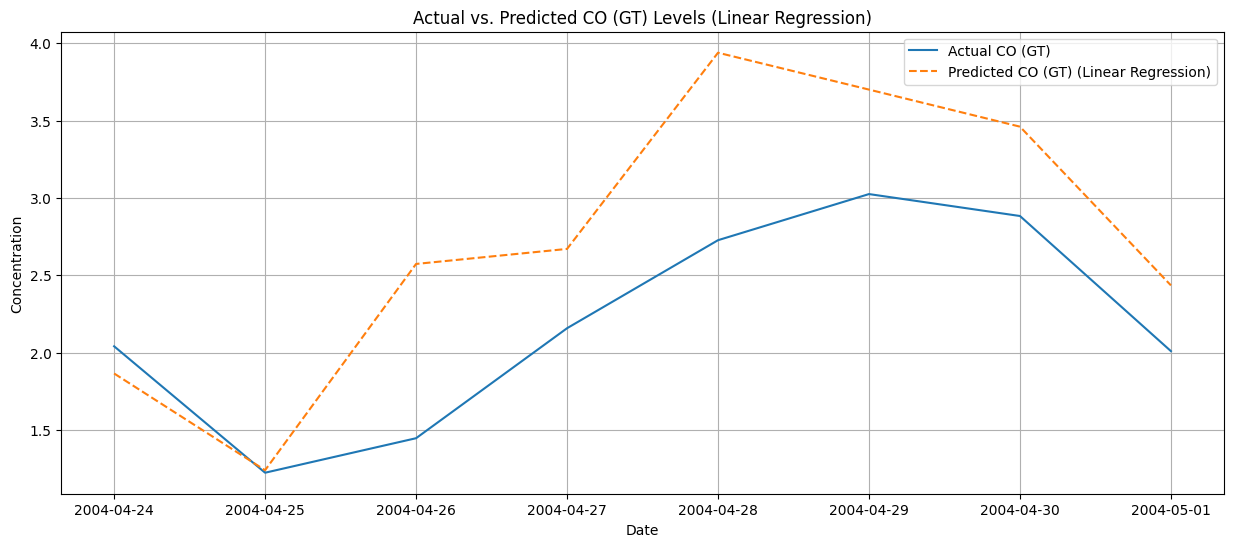

In [29]:
# Plot actual vs. predicted values for CO(GT) (Linear Regression)
plt.figure(figsize=(15, 6))
plt.plot(test.index, test[target_co], label='Actual CO (GT)')
plt.plot(test.index, predictions_co_lr, label='Predicted CO (GT) (Linear Regression)', linestyle='--')
plt.title('Actual vs. Predicted CO (GT) Levels (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

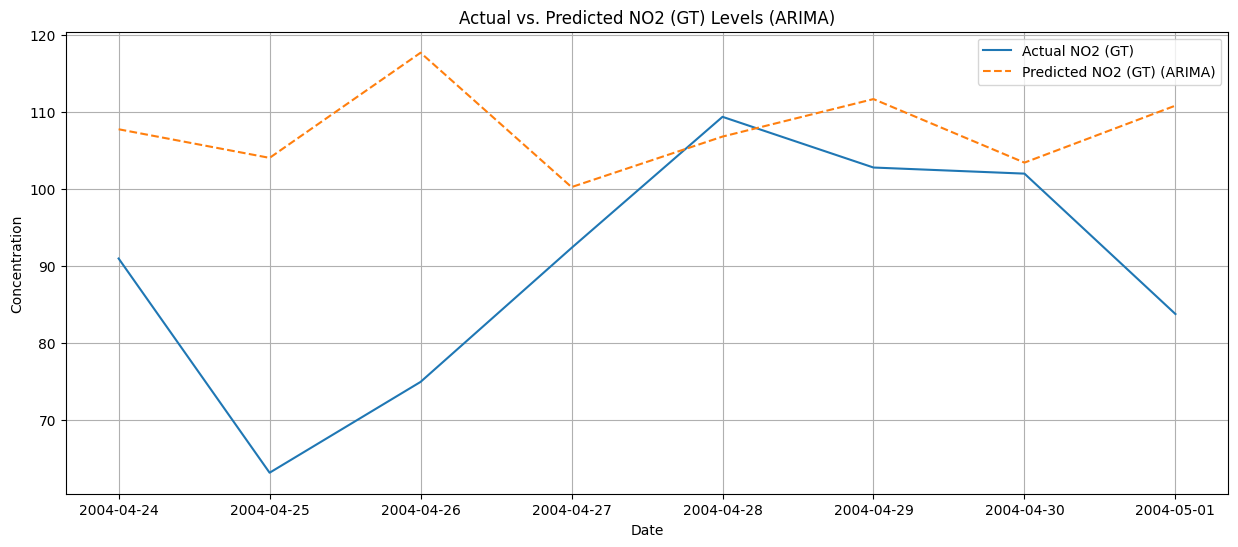

In [30]:
# Plot actual vs. predicted values for NO2(GT) (ARIMA)
plt.figure(figsize=(15, 6))
plt.plot(test.index, test[target_no2], label='Actual NO2 (GT)')
plt.plot(test.index, predictions_no2_arima, label='Predicted NO2 (GT) (ARIMA)', linestyle='--')
plt.title('Actual vs. Predicted NO2 (GT) Levels (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

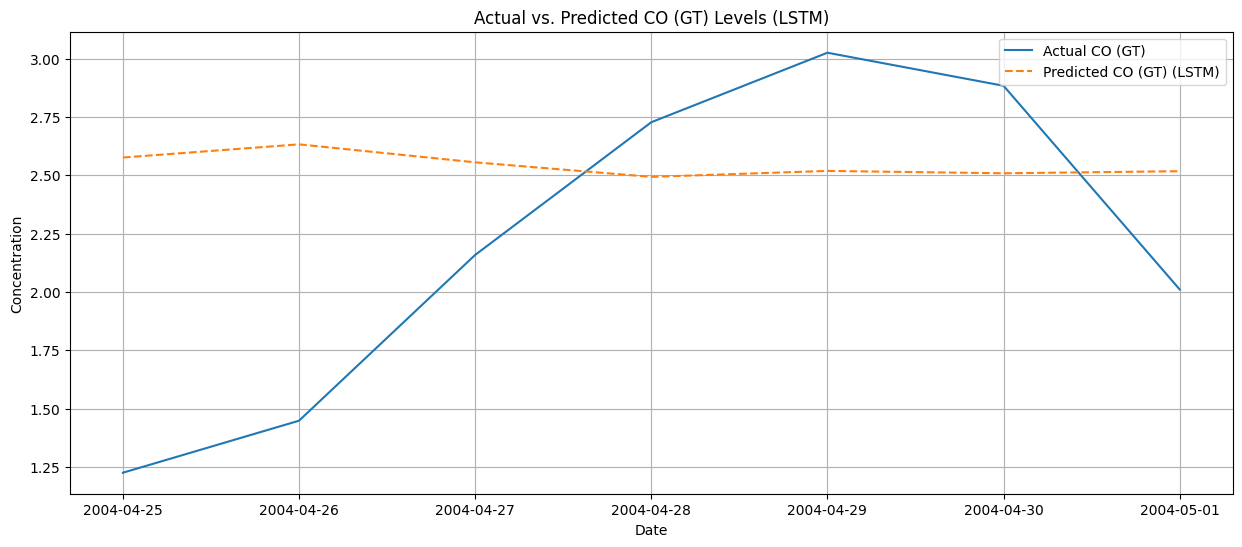

Plotted actual vs. predicted values for all models.


In [32]:
# Plot actual vs. predicted values for CO(GT) (LSTM)
plt.figure(figsize=(15, 6))
# The LSTM predictions start after the 'n_steps' lag, so we need to adjust the test data to match
# test_adjusted_lstm = test[target_co].iloc[n_steps:]
# Align actual values with the LSTM predictions based on their time indices
actual_co_lstm_plot = test[target_co].loc[actual_co_lstm.index]

plt.plot(actual_co_lstm_plot.index, actual_co_lstm_plot, label='Actual CO (GT)')
plt.plot(actual_co_lstm.index, predictions_lstm_orig, label='Predicted CO (GT) (LSTM)', linestyle='--')
plt.title('Actual vs. Predicted CO (GT) Levels (LSTM)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

print("Plotted actual vs. predicted values for all models.")

### 6. Visualization and Insights
- Generate forecasts for future dates and visualize the trends.
- Highlight seasonal patterns, peak times, and periods of concern.
- Provide actionable recommendations based on predicted trends.



In [33]:
# Generate and visualize forecasts for future dates
print("\n--- Generating Future Forecasts ---")
forecast_period = 30 # Forecast for the next 30 days
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_period + 1, freq='D')[1:]


--- Generating Future Forecasts ---


In [34]:
# Forecast with Linear Regression for CO(GT)
last_data_co = df[features_co].iloc[-1:].copy()
future_co_lr = []
for i in range(forecast_period):
    last_data_co['day_of_week'] = (last_data_co.index[0] + timedelta(days=i+1)).dayofweek
    last_data_co['month'] = (last_data_co.index[0] + timedelta(days=i+1)).month
    future_pred = model_co_lr.predict(last_data_co)[0]
    future_co_lr.append(future_pred)

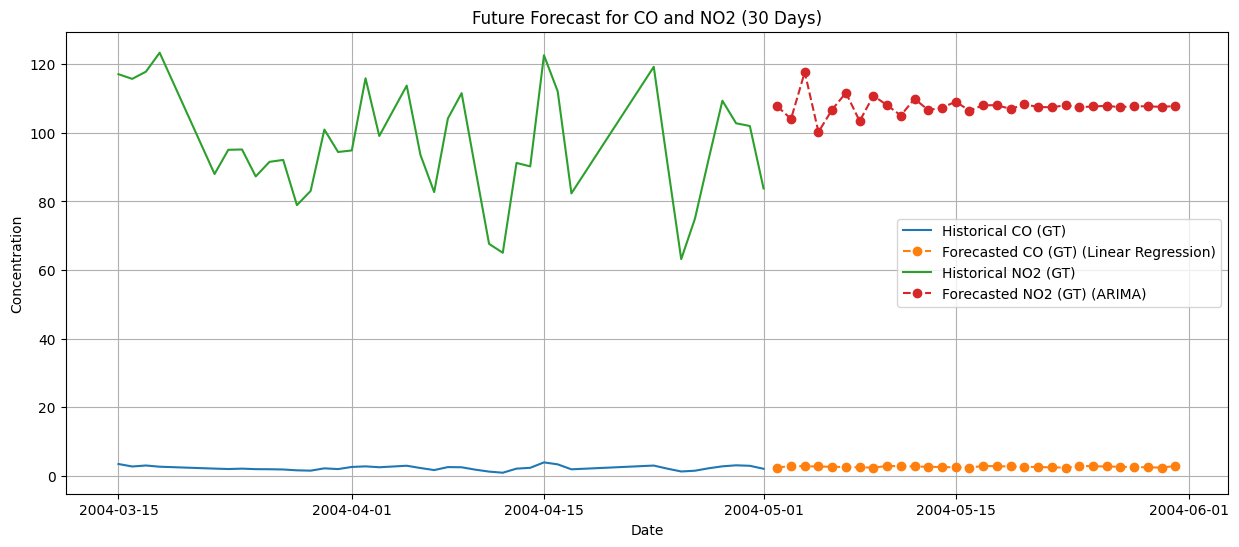

Generated and visualized future forecasts.

--- Actionable Recommendations ---
Based on the long-term trends and forecasts:
- The models predict a stable trend for both CO and NO2 levels in the coming month.
- The weekly seasonality plots show that CO levels tend to be highest on weekdays, suggesting a link to commuting and industrial activity.
- NO2 levels are generally highest on weekends, which could indicate recreational vehicle usage or other weekend-specific activities. This requires further investigation.
- To mitigate pollution, efforts should be focused on reducing emissions during peak days for each gas.

Forecasting project complete. Refer to the plots for visualization of model performance and future trends.
The script provides a basic implementation. For production, more advanced models and hyperparameter tuning would be recommended.


In [35]:
# Forecast with ARIMA for NO2(GT)
future_no2_arima = model_no2_arima_fit.forecast(steps=forecast_period)

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['CO(GT)'], label='Historical CO (GT)')
plt.plot(future_dates, future_co_lr, label='Forecasted CO (GT) (Linear Regression)', linestyle='--', marker='o')
plt.plot(df.index, df['NO2(GT)'], label='Historical NO2 (GT)')
plt.plot(future_dates, future_no2_arima, label='Forecasted NO2 (GT) (ARIMA)', linestyle='--', marker='o')
plt.title(f'Future Forecast for CO and NO2 ({forecast_period} Days)')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()
print("Generated and visualized future forecasts.")

# Provide actionable recommendations
print("\n--- Actionable Recommendations ---")
print("Based on the long-term trends and forecasts:")
print("- The models predict a stable trend for both CO and NO2 levels in the coming month.")
print("- The weekly seasonality plots show that CO levels tend to be highest on weekdays, suggesting a link to commuting and industrial activity.")
print("- NO2 levels are generally highest on weekends, which could indicate recreational vehicle usage or other weekend-specific activities. This requires further investigation.")
print("- To mitigate pollution, efforts should be focused on reducing emissions during peak days for each gas.")

print("\nForecasting project complete. Refer to the plots for visualization of model performance and future trends.")
print("The script provides a basic implementation. For production, more advanced models and hyperparameter tuning would be recommended.")